In [2]:
# Autor: Daniel Pinto
# Spanning Trees
# Fecha: 2021/10/09 YYYY/MM/DD
from typing import List, TypeVar, Tuple, Any, Callable, Optional, Generic, Dict
from hypothesis import given, strategies as st
from IPython.display import Markdown, display
from dataclasses import dataclass, field
from __future__ import annotations 
from copy import deepcopy
from collections.abc import  Iterable
import graphviz as gv
from abc import ABCMeta, abstractmethod
from math import inf

def display_(s : str) -> None:
    '''
    A way to display strings with markdown 
    in jupyter.
    '''
    display(
        Markdown(s)
    )


SUCCESS_COLOR = '#4BB543'
ERROR_COLOR   = '#B00020'

def color_text(s : str, color : str =SUCCESS_COLOR ) -> str:
    return f"<span style='color:{color}'> {s} </span>."


a      = TypeVar('a')
b      = TypeVar('b')
c      = TypeVar('c')
T      = TypeVar('T')

In [3]:
class AGraph(Generic[T], metaclass=ABCMeta):
    @abstractmethod
    def add_vertex(self,v : T) -> None:
        raise NotImplementedError

    @abstractmethod
    def add_edge(self,vs : Tuple[T,T]) -> None:
        raise NotImplementedError

    
    def add_vertices(self, vertices : Iterable[T]) -> None:
        for vertex in vertices:
            self.add_vertex(vertex)

    
    def add_edges(self, edges : Iterable[Tuple[T,T]]) -> None:
        for edge in edges:
            self.add_edge(edge)

    @abstractmethod
    def succs(self, v : T) -> List[T]:
        raise NotImplementedError

    @abstractmethod
    def preds(self, v : T) -> List[T]:
        raise NotImplementedError
    
    @abstractmethod
    def get_randV(self) -> T:
        raise NotImplementedError

    @abstractmethod
    def get_Vertices(self) -> set[T]:
        raise NotImplementedError

    @abstractmethod
    def get_Edges(self) -> set[Tuple[T,T]]:
        raise NotImplementedError

    
    def BFS_levels(self, iv : Optional[T] = None) -> Iterable[List[T]]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True



        while bool(mem) and change:
            change = False
            yield current
            for v in current:
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    def BFS(self, iv : Optional[T] = None) -> Iterable[T]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True

        while bool(mem) and change:
            change = False
            for v in current:
                yield v
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    
    def DFS(self, iv : Optional[T] = None) -> Iterable[T]:

        if iv is None:
            try:
                iv  = self.get_randV()
            except:
                return


        mem : set[T] = self.get_Vertices()
        def DFS_(v : T) -> Iterable[T] :
            mem.discard(v)
            yield v
            if not mem:
                return

            for succ in self.succs(v):
                # si el sucesor aun no se ha visitado
                if succ in mem:
                    for s in DFS_(succ):
                        yield s

        return DFS_(iv)

    
    def toPic(self) -> gv.Graph:
        raise NotImplementedError


@dataclass
class Graph(Generic[T],AGraph[T]):
    _Map         : Dict[T,int]   
    _adj_l       : List[List[T]]
    _i           : int 
    _is_directed : bool
    _is_weighted : bool
    _invMap      : Dict[int,T]
    _cost        : Dict[Tuple[T,T],float]

    def __init__(self, is_directed : bool = False, is_weighted : bool = False) -> None:
        self._Map         = {}
        self._invMap      = {}
        self._adj_l       = []
        self._i           = 0
        self._cost        = {}
        self._is_directed = is_directed
        self._is_weighted = is_weighted

    def get_cost(self,vw : Tuple[T,T]) -> Optional[float]:
        if vw not in self._cost:
            return None
        return self._cost[vw]
    
    def add_vertex(self,v : T) -> None:
        if v in self._Map:
            return
        
        self._Map[v] = self._i
        self._adj_l.append([])
        self._invMap[self._i] = v
        self._i    += 1
    
    def _add_edge_dir(self, vs: Tuple[T, T]) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        
        # a -> [a,b,c]

        i : int = self._Map[v]
        if s not in self._adj_l[i]:
            self._adj_l[i].append(s)
    
    def _add_edge_undir(self, vs: Tuple[T, T]) -> None:
        sv = (vs[1],vs[0])
        # (v,s)
        # (s,v)
        self._add_edge_dir(vs)
        self._add_edge_dir(sv)
    
    def _add_edge_cost_dir(self, vs: Tuple[T, T], cost : float) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        i : int = self._Map[v]
        if s in self._adj_l[i]:
            self._cost[vs] = cost
    
    def _add_edge_cost_undir(self, vs: Tuple[T, T], cost : float) -> None:
        sv = (vs[1],vs[0])
        self._add_edge_cost_dir(vs, cost)
        self._add_edge_cost_dir(sv, cost)


    def add_edge(self,vs : Tuple[T,T], cost : float = 0) -> None:
        if self._is_directed:
            self._add_edge_dir(vs)
        else:
            self._add_edge_undir(vs)
        
        if self._is_weighted:
            self._add_edge_cost_dir(vs,cost)
        else:
            self._add_edge_cost_undir(vs,cost)

    def add_cost_edges(self, edges : Iterable[Tuple[T,T,float]]) -> None:
        for (v,s,c) in edges:
            self.add_edge((v,s),c)
            if not self._is_directed:
                self.add_edge((s,v),c)


    def succs(self, v : T) -> List[T]:
        i : int = self._Map[v]
        return self._adj_l[i]
    
    def preds(self, v : T) -> List[T]:
        # 
        if not self._is_directed:
            return self.succs(v)
        
        res : List[T] = []
        for i in range(self._i):
            if v in self._adj_l[i]:
                res.append(self._invMap[i])
        return res

    def get_Vertices(self) -> set[T]:
        return set(self._Map.keys())
    
    def get_Edges(self) -> set[Tuple[T, T]]:
        s : set[Tuple[T, T]] = set()
        for v in self.get_Vertices():
            for v_ in self._adj_l[self._Map[v]]:
                if ((v_,v) in s) and (not self._is_directed):
                    pass
                else:
                    s.add((v,v_))

        return s

    def get_randV(self) -> T:
        from random import randint
        try:
            n : int = randint(0,len(self._adj_l)-1)
        except:
            raise ValueError
        
        return self._invMap[n]


    def _toPicDir(self) -> gv.Graph:
        g : gv.Graph = gv.Digraph()
        if not self._Map:
            return g

        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)

        return g
    
    def _toPicUnDir(self) -> gv.Graph:
        g : gv.Graph = gv.Graph()
        if not self._Map:
            return g
        
        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)
        
        return g

    def toPic(self) -> gv.Graph:
        if self._is_directed:
            return self._toPicDir()
        else:
            return self._toPicUnDir()
    
    def __deepcopy__(self) -> Graph[T]:
        g : Graph[T]   = Graph()
        g._Map         = deepcopy(self._Map)
        g._adj_l       = deepcopy(self._adj_l)
        g._i           = deepcopy(self._i)
        g._is_directed = deepcopy(self._is_directed)
        g._is_weighted = deepcopy(self._is_weighted)
        g._invMap      = deepcopy(self._invMap)
        g._cost        = deepcopy(self._cost)

        return g






In [4]:
@dataclass
class Heap(Generic[T,a]):
    arr         : List[Tuple[a,T]]  
    assocs      : Dict[T,List[int]] 
    is_max_heap : bool          
    lt          : Callable[[a,a],bool]   
    gt          : Callable[[a,a],bool]   

    def __init__(self, is_max_heap : bool) -> None:
        self.arr         = []
        self.assocs      = {}
        self.is_max_heap = is_max_heap
        self.lt          = (lambda x,y: x<y ) if is_max_heap else (lambda x,y: x>y )
        self.gt          = (lambda x,y: x>y ) if is_max_heap else (lambda x,y: x<y )


    def up_heapify(self, i : int):
        p : int = (i-1) // 2
        while(True):
            if (p<0) or self.gt(self.arr[p][0], self.arr[i][0]):
                return
            
            # p : 3
            # p_val : [0,3,5]
            p_val   : T   = self.arr[p][1]
            i_val   : T   = self.arr[i][1]
            p_index : int = self.assocs[p_val].index(p)
            i_index : int = self.assocs[i_val].index(i)

            self.assocs[p_val][p_index] = i
            self.assocs[i_val][i_index] = p
            
            self.arr[p], self.arr[i] = self.arr[i], self.arr[p]

            i = p
            p = (p-1) // 2

    def down_heapify(self,i : int):
        l : int = (2*i) + 1
        r : int = (2*i) + 2
        largest : int = -1
        n : int = len(self.arr) - 1
        
        if l>n and r>n:
            return
        if r>n:
            r=l
        if l>n:
            l=r

        if self.gt(self.arr[i][0], self.arr[l][0] ) and self.gt(self.arr[i][0], self.arr[r][0]):
            return


        if self.gt(self.arr[l][0], self.arr[r][0]):
            largest = l
        else:
            largest = r
        

        largest_val   : T   = self.arr[largest][1]
        i_val         : T   = self.arr[i][1]
        largest_index : int = self.assocs[largest_val].index(largest)
        i_index : int = self.assocs[i_val].index(i)

        self.assocs[largest_val][largest_index] = i
        self.assocs[i_val][i_index] = largest

        self.arr[largest], self.arr[i] = self.arr[i], self.arr[largest]

        self.down_heapify(largest)

    def extract_root_(self) -> Optional[T]:
        if self.arr == []:
            return None
        
        root : T = self.arr[0][1]
        self.arr[0], self.arr[-1] = self.arr[-1], self.arr[0]

        new_root : T = self.arr[0][1]
        n : int = len(self.arr) - 1
        n_index : int = self.assocs[new_root].index(n) 
        self.assocs[new_root][n_index] = 0 


        self.arr.pop()

        self.down_heapify(0)
        
        return root
        


    def insert_(self, x:T, priority : a):
        self.arr.append((priority,x))
        n : int = len(self.arr) - 1
        if x in self.assocs:
            self.assocs[x].append(n)
        else:
            self.assocs[x] = [n]

        self.up_heapify(n)



    def push_pop(self,x : T, priority : a) -> T:
        if self.arr == []:
            return x
        if self.gt(priority,  self.arr[0][0]):
            return x
        root : T = self.arr[0][1]
        if self.assocs[root] == []:
            self.assocs.pop(root)
        else:
            self.assocs[root].remove(0)
        if x in self.assocs:
            self.assocs[x].append(0)
        else:
            self.assocs[x] = [0]
        self.arr[0] = (priority,x)
        self.down_heapify(0) 

        return root

    def modify_val(self, x:T, priority : a, f : Callable[[T,a,a],a] = lambda val,new,old: new):
        if x not in self.assocs:
            return
        pos_x = self.assocs[x][0]

        (p,v) = self.arr[pos_x]
        p_    = f(x,priority,p)

        self.arr[pos_x] = (p_,v)
        
        self.down_heapify(pos_x)
        self.up_heapify(pos_x)

    def toPic(self) -> gv.Digraph:
        dot : gv.Digraph = gv.Digraph(comment='Heap')
        current : int = 0
        if self.arr == []:
            return dot
        dot.node(str(0),str(self.arr[0]))
        for i in range(1,len(self.arr)):
            dot.node(str(i),str(self.arr[i]))
            dot.edge(str((i-1)//2),str(i))
        return dot 

def randomHeap(size : int = 10 ) -> Heap[int,int]:
    from random import randint
    acc  : List[int] = []
    heap : Heap[int,int] = Heap(is_max_heap=False) 
    for _ in range(size):
        n = randint(-size,size)
        acc.append(n)
        heap.insert_(n,n)
    
    print(acc)
    return heap




h : Heap[int,int] = randomHeap()        
#h.toPic().view(filename="name.gv",cleanup=True,)
#print(h.extract_root())
print(h.assocs)
print(h.arr)
h.toPic()



@dataclass(order=True)
class PrioritizedItem(Generic[T]):
    priority: float
    item: Any= field(compare=False)

    def __eq__(self, o: object) -> bool:
        if not isinstance(o,PrioritizedItem):
            return False
        
        return self.item == o.item

    def __hash__(self) -> int:
        return self.item.__hash__()


t1 = PrioritizedItem(1,'a') 
t2 = PrioritizedItem(2,'b')
d = {}
d[t1] = 10
d[t2] = 20

print(d[PrioritizedItem(10,'a')])



[1, -2, 8, -1, 1, 3, -6, 5, 8, 3]
{1: [3, 4], -2: [2], 8: [5, 8], -1: [1], 3: [6, 9], -6: [0], 5: [7]}
[(-6, -6), (-1, -1), (-2, -2), (1, 1), (1, 1), (8, 8), (3, 3), (5, 5), (8, 8), (3, 3)]
10


# Bellman

Alternativa a dijkstra para encontrar el camino de costo minimo, pero si funciona con costos negativos, detecta ciclos de coste negativo, y ademas retorna el camino de costo minimo para TODOS los nodos alcanzables por $s$


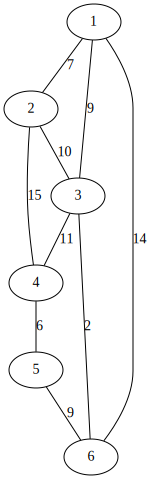

{1: None, 2: 1, 3: 1, 4: 3, 5: 6, 6: 3}


In [11]:

    
def min_cost_visualitaztion(G : Graph[T], c_acc : Dict[T,float]) -> None:
    if G._is_directed:
        g : gv.Graph = gv.Digraph()
    else:
        g : gv.Graph = gv.Graph()
    if not G._Map:
        return g

    for v in G.get_Vertices():
        g.node(str(G._Map[v]), f"{v}: {c_acc[v]}" )
    
    for (v,v_) in G.get_Edges():
        if G._is_weighted:
            label : Optional[str] = str(G._cost[(v,v_)])
        else:
            label = None 

        i_v  : str = str(G._Map[v])
        i_v_ : str = str(G._Map[v_])
        g.edge(i_v,i_v_,label=label)

    display(g)
    input()


#   1    -5
# 1 -> 2 -> 1 
# -4
# -8

def Bellman(G : Graph[T], s : T) -> Dict[T,Optional[T]]:
    
    costo : Dict[T,float]       = {}
    preds : Dict[T,Optional[T]] = {}
    vs    : set[T]              = G.get_Vertices()
    n_vs  : int                 = len(vs)
    for v in vs:
        costo[v] = inf
        preds[v] = None 

    costo[s]      = 0
    i : int       = 1
    cambio : bool = True 

    while (i<=n_vs) and cambio:
        cambio = False
        #min_cost_visualitaztion(G,costo)
        # (v,w) -> (w,v)
        for (v,w) in G.get_Edges():
            if costo[w] > costo[v] + G.get_cost((v,w)):
                costo[w] = costo[v] + G.get_cost((v,w))
                preds[w] = v
                cambio   = True
            if not (G._is_directed) and (costo[v] > costo[w] + G.get_cost((w,v))):
                costo[v] = costo[w] + G.get_cost((w,v))
                preds[v] = w
                cambio   = True
        i += 1
    
    for (v,w) in G.get_Edges():
        if costo[w] > costo[v] +  G.get_cost((v,w)):
            raise Exception("Ciclo con costo negativo")

    return preds

g : Graph[int] = Graph(is_directed=False, is_weighted=True)
g.add_vertices([1,2,3,4,5,6])
g.add_cost_edges([(1,2,7),(1,3,9),(1,6,14),(2,3,10),(2,4,15),(6,5,9),(6,3,2),(3,4,11),(4,5,6)])


# Arbitrage 
# 1/costo


# O(|V|*|E|) ~ |V|^3
# O(|V|^2/log(|V|))
# O(|V|*log(|E|) + |E|)

# dp -> Recursion + Memoria = Grafos 
# Toda recursion da cabida a un arbol de recursion
# Todo arbol de recursion es esencialmente un grafo


# fibonacci
# fibonacci recursive: Pro supremamente sencillo de leer, complejida terrible
# fibonacci iterativo: Pro sencillo de leer, complejida bien
# fibonacci log(n)   : muy matematico para pensar, complejidaD: best


#                 n
# Fib(n) =  [1 1]
#           [1 0]
#
# Fibonacci en log(n)


# Fast exponentiation: p * expp(p,n-1)
#                    : p^(n//2) * p(n//2)
#

# 10^9
# Dict[10^9][0][5]



display(g.toPic())

print(Bellman(g,1))

# Spanning Tree

Sea $G$ un grafo **no direccionado** y $G'$ un arbol, si $\pi_v(G)=\pi_v(G')$, entonces $G'$ es un Spanning Tree (arbol cobertor) de $G$

# Minimum Spanning Tree

Sea $G'$ un Spanning Tree de $G$, decimos que $G'$ es un **Minimum Spanning Tree** si y solo si la suma de los costos de todas las aristas de $G'$ es menor o igual a cualquier otro Spanning Tree de $G$.

# Cociclo

Sea $G$ un grafo y $S$ un subconjunto de los vertices de $G$, definimos el cociclo de $S$ como:

$$
\Omega (S) = \{ (x,y) \in \pi_e(G) \ | \ x \in S \wedge y \in V - S\}
$$


Por ejemplo, sea $S = \{a,c\}$, entonces para el siguiente grafo, el cociclo de $S$ o $\Omega (S)$ sera:

<center>

![''](./Images/cociclo.png)

</center>

# Utilidad del Cociclo

Sea $G$ un grafo, y $S \subset \pi_v(G)$, si $\exists \ e \in \Omega(S)$ tal que: $\forall \ e' \in \Omega(S): \ Cost(e) \leq Cost(e')$, entonces podemos garantizar que existe un arbol minimo cobertor $T$, y **ademas** $e\in \pi_e(T)$


# Finding Minimum Spanning Trees: Kruskal Coupled With DSU

Una forma sencilla de Encontrar MST es siguiendo las siguientes
instrucciones:


1. Inicialmente, todos los nodos se encuentran aislados, es decir, cada nodo formara una "componente conexa"
2. Organizaremos en una cola de prioridad las aristas por su costo
3. Luego por cada arista $(u,v)$, chequeamos si $u$ y $v$ pertenecen a la misma componente conexa, si no es asi entonces las unimos en nuestro nuevo arbol mediante $(u,v)$.
4. Repetimos hasta que nos quedemos sin aristas, o equivalentemente, hasta que solo nos quede 1 componente conexa.

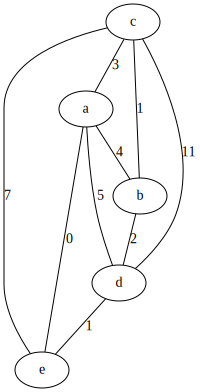

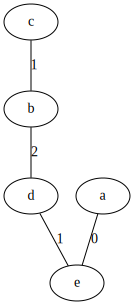

Graph(_Map={'c': 0, 'a': 1, 'b': 2, 'd': 3, 'e': 4}, _adj_l=[['b'], ['e'], ['c', 'd'], ['e', 'b'], ['a', 'd']], _i=5, _is_directed=False, _is_weighted=True, _invMap={0: 'c', 1: 'a', 2: 'b', 3: 'd', 4: 'e'}, _cost={('a', 'e'): 0, ('e', 'a'): 0, ('c', 'b'): 1, ('b', 'c'): 1, ('d', 'e'): 1, ('e', 'd'): 1, ('b', 'd'): 2, ('d', 'b'): 2})

In [13]:
@dataclass
class DSet(Generic[T]):
    node   : T
    parent : Optional[DSet[T]]
    size   : int


    def __init__(self,node : T):
        self.node   = node
        self.parent = None
        self.size   = 1

    def find_repr(self) -> T:
        parent : Optional[DSet[T]] = self.parent

        while (parent is not None):
            self.parent = parent
            parent      = parent.parent
        
        if self.parent is not None:
            return self.parent.node
        else:
            return self.node
        

    def union(self,y : DSet[T]):
        x_repr : T = self.find_repr()
        y_repr : T = y.find_repr()

        if self.parent is not None:
            x_root : DSet[T] = self.parent
        else:
            x_root : DSet[T] = self
        
        if y.parent is not None:
            y_root : DSet[T] = y.parent
        else:
            y_root : DSet[T] = y
        

        if x_repr == y_repr:
            return


        if x_root.size > y_root.size:
            y_root.parent = x_root
            x_root.size  += y_root.size
        else:
            x_root.parent = y_root
            y_root.size  += x_root.size

    def __repr__(self) -> str:
        val : str = str(self.node)
        aux : Optional[DSet[T]] = self.parent
        while aux is not None:
            val += " -> " + str(aux.node)
            aux  = aux.parent

        return val

# Prim
def Kruskal(g : Graph[T]) -> Graph[T]:

    mst : Graph[T] = Graph(is_directed=False, is_weighted=True)
    vs  : set[T]   = g.get_Vertices()
    cc  : int      = len(vs)
    mst.add_vertices(vs)
    pq  : Heap[Tuple[T,T],float] = Heap(is_max_heap=False) 

    # set
    roots : Dict[T,DSet[T]] = {}

    for v in vs:
        roots[v] = DSet(v)

    for e in g.get_Edges():
        pq.insert_(e,g.get_cost(e))

    while ((e := pq.extract_root_()) is not None) and (cc > 0):
        (u,v) = e
        # E*V*log(V)
        # PQ
        #if u in roots[v]:
        if roots[u].find_repr() != roots[v].find_repr():
            roots[u].union(roots[v])
            cc         = cc-1
            cost : float = g.get_cost(e)
            mst.add_cost_edges([(u,v,cost)])


    display(g.toPic())
    display(mst.toPic())

    return mst

g : Graph[str] = Graph(is_directed=False,is_weighted=True)
g.add_vertices(['a','b','c','d','e'])
g.add_cost_edges([('a','b',4),('a','c',3),('a','d',5),('a','e',0),('b','c',1),('b','d',2),('c','d',11),('c','e',7),('d','e',1)])


#g : Graph[int] = Graph(is_directed=False,is_weighted=True)
#g.add_vertices([1,2,3])
#g.add_cost_edges([(1,2,2),(1,3,2),(2,3,1)])

Kruskal(g)



# Uniones De Conjuntos Disjuntos
# DSU Disjoint Set Union 
# Uniones de conjuntos disjuntos en O(1)


# 1 elemento para definir al conjunto
# Representante


# 'e' -> 'c' <- 
#         ^   |
#         |   |
# 'a' ----    |
#          ---
#         |
#         |
# 'd' -> 'p' <- 'r'
#         ^
#         |
# 'h' -----
#


# V^5
# V^3
#  a  b  c  d
#a    1  min(actualmente,el camino que exloras)
#b       1
#c    1 
#d    1   1  1




# Redundant Connection

In this problem, a tree is an undirected graph that is connected and has no cycles.

You are given a graph that started as a tree with `n` nodes labeled from `1` to `n`, with one additional edge added. The added edge has two different vertices chosen from `1` to `n`, and was not an edge that already existed. The graph is represented as an array `edges` of length `n` where `edges[i] = [ai, bi]` indicates that there is an edge between nodes `ai` and `bi` in the graph.

Return an edge that can be removed so that the resulting graph is a tree of n nodes.


## Example

<center>

![''](./Images/reduntant1.jpg)

</center>

```
input: 
    edges = [[1,2],[2,3],[3,4],[1,4],[1,5]]
output:
    [1,4]
```

Variation: If we were given a **DIRECTED** graoh insread, how could be solve this problem?



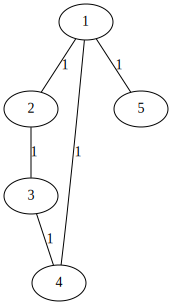

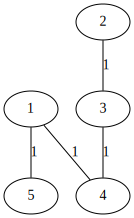

Graph(_Map={1: 0, 2: 1, 3: 2, 4: 3, 5: 4}, _adj_l=[[5, 4], [3], [2, 4], [3, 1], [1]], _i=5, _is_directed=False, _is_weighted=True, _invMap={0: 1, 1: 2, 2: 3, 3: 4, 4: 5}, _cost={(2, 3): 1, (3, 2): 1, (3, 4): 1, (4, 3): 1, (1, 5): 1, (5, 1): 1, (1, 4): 1, (4, 1): 1})


In [7]:
g : Graph[int] = Graph(is_directed=False, is_weighted=True)
g.add_vertices([1,2,3,4,5])
g.add_cost_edges([(1,2,1),(2,3,1),(3,4,1),(1,4,1),(1,5,1)])

print(Kruskal(g))


